In [1]:
from jmetal.algorithm.singleobjective.evolution_strategy import EvolutionStrategy
from jmetal.problem import Sphere
from jmetal.core.problem import Problem
from jmetal.problem.singleobjective.unconstrained import Sphere, Rastrigin
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BinaryTournamentSelection, PolynomialMutation, SBXCrossover
from jmetal.core.operator import Mutation
from jmetal.core.solution import BinarySolution, Solution, FloatSolution
from jmetal.util.ckecking import Check
from jmetal.core.observer import Observer

import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(0, r'C:\Users\kriczq\studia\io\AGHComputationalIntelligence')

In [3]:
from framework.problems.singleobjective.ackley import Ackley
from framework.problems.singleobjective.griewank import Griewank
from framework.problems.singleobjective.schwefel import Schwefel

from framework.runner.multi_algorithm_runner import  ExecutionUnit, MultiAlgorithmRunner

In [4]:
class StoreObserver(Observer):
    def __init__(self, frequency: float = 1.0) -> None:
        self.display_frequency = frequency
        self.savedResults = []

    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']            
        if (evaluations % self.display_frequency) == 0 and solutions:
            if type(solutions) == list:
                fitness = solutions[0].objectives
            else:
                fitness = solutions.objectives

            self.savedResults.append(fitness)

    def get_results(self):
        return self.savedResults

In [8]:
class ExtendedPolynomialMutation(Mutation[FloatSolution]):
    def __init__(self, probability: float, distribution_index: float = 0.20, number_of_best = 5, closer_to_best_probability: float = 0.0, further_from_worst_probability: float = 0.0):
        super(ExtendedPolynomialMutation, self).__init__(probability=probability)
        self.distribution_index = distribution_index
        self.closer_to_best_probability = closer_to_best_probability
        self.further_from_worst_probability = further_from_worst_probability
        self.best_solutions = []
        self.worst_solutions = []
        self.number_of_best = number_of_best

    def execute(self, solution: FloatSolution) -> FloatSolution:
        Check.that(issubclass(type(solution), FloatSolution), "Solution type invalid")
        copied_solution = solution.__copy__()

        if copied_solution not in self.best_solutions:
            self.best_solutions.append(copied_solution)
        self.best_solutions.sort(key=lambda x: x.objectives[0], reverse=False)
        self.best_solutions = self.best_solutions[:self.number_of_best]

        if copied_solution not in self.worst_solutions:
            self.worst_solutions.append(copied_solution)
        self.worst_solutions.sort(key=lambda x: x.objectives[0], reverse=True)
        self.worst_solutions = self.worst_solutions[:self.number_of_best]

        for i in range(solution.number_of_variables):
            rand = random.random()

            if rand <= self.probability:
                y = solution.variables[i]
                yl, yu = solution.lower_bound[i], solution.upper_bound[i]

                if yl == yu:
                    y = yl
                else:
                    delta1 = (y - yl) / (yu - yl)
                    delta2 = (yu - y) / (yu - yl)
                    rnd = random.random()
                    mut_pow = 1.0 / (self.distribution_index + 1.0)
                    if rnd <= 0.5:
                        xy = 1.0 - delta1
                        val = 2.0 * rnd + (1.0 - 2.0 * rnd) * (pow(xy, self.distribution_index + 1.0))
                        deltaq = pow(val, mut_pow) - 1.0
                    else:
                        xy = 1.0 - delta2
                        val = 2.0 * (1.0 - rnd) + 2.0 * (rnd - 0.5) * (pow(xy, self.distribution_index + 1.0))
                        deltaq = 1.0 - pow(val, mut_pow)

                    y += deltaq * (yu - yl)
                    if y < solution.lower_bound[i]:
                        y = solution.lower_bound[i]
                    if y > solution.upper_bound[i]:
                        y = solution.upper_bound[i]

                solution.variables[i] = y
            elif rand <= self.probability + self.closer_to_best_probability:
                one_of_the_best = random.choice(self.best_solutions)
                solution.variables[i] = one_of_the_best.variables[i]
            elif rand <= self.probability + self.closer_to_best_probability + self.further_from_worst_probability:
                one_of_the_worst = random.choice(self.worst_solutions)
                diff = solution.variables[i] - one_of_the_worst.variables[i]
                calculated_value = solution.variables[i] + diff / 100
                solution.variables[i] = max(min(calculated_value,solution.upper_bound[i]),solution.lower_bound[i])

        return solution

    def get_name(self):
        return 'Extended polynomial mutation' 

In [9]:
class CognitivePolynomialMutation(Mutation[FloatSolution]):
    def __init__(self, probability: float, distribution_index: float = 0.20,
    look_at_others_probability: float = 0.2,
    lambda_: int = 20,
    vector_factor: float = 0.7):
        super(CognitivePolynomialMutation, self).__init__(probability=probability)
        self.distribution_index = distribution_index
        self.look_at_others_probability = look_at_others_probability
        self.lambda_ = lambda_
        self.vector_factor = vector_factor
        
        self.follow_solutions = []

    def execute(self, solution: FloatSolution) -> FloatSolution:
        Check.that(issubclass(type(solution), FloatSolution), "Solution type invalid")
        copied_solution = solution.__copy__()
        if copied_solution not in self.follow_solutions:
            self.follow_solutions.append(copied_solution)
        self.follow_solutions.sort(key=lambda x: x.objectives[0], reverse=False)
        self.follow_solutions = self.follow_solutions[:self.lambda_]

        vector = self.get_follow_vector()

        for i in range(solution.number_of_variables):
            rand = random.random()
            
            if rand <= self.probability:
                y = solution.variables[i]
                yl, yu = solution.lower_bound[i], solution.upper_bound[i]

                if yl == yu:
                    y = yl
                else:
                    delta1 = (y - yl) / (yu - yl)
                    delta2 = (yu - y) / (yu - yl)
                    rnd = random.random()
                    mut_pow = 1.0 / (self.distribution_index + 1.0)
                    if rnd <= 0.5:
                        xy = 1.0 - delta1
                        val = 2.0 * rnd + (1.0 - 2.0 * rnd) * (pow(xy, self.distribution_index + 1.0))
                        deltaq = pow(val, mut_pow) - 1.0
                    else:
                        xy = 1.0 - delta2
                        val = 2.0 * (1.0 - rnd) + 2.0 * (rnd - 0.5) * (pow(xy, self.distribution_index + 1.0))
                        deltaq = 1.0 - pow(val, mut_pow)

                    y += deltaq * (yu - yl)
                    if y < solution.lower_bound[i]:
                        y = solution.lower_bound[i]
                    if y > solution.upper_bound[i]:
                        y = solution.upper_bound[i]

                solution.variables[i] = y
            elif rand <= self.probability + self.look_at_others_probability:
                diff = vector[i] - solution.variables[i]
                calculated_value = solution.variables[i] + self.vector_factor * diff
                solution.variables[i] = max(min(calculated_value, solution.upper_bound[i]), solution.lower_bound[i])

        return solution

    # fitness -> 0, m -> 1
    # fitness -> inf, m -> -0.001
#     def get_fitness_factor(self, fitness, avg_fitness):
#         if (fitness <= avg_fitness):
#             return 1 - (fitness / avg_fitness)
#         else:
#             return 0 * (fitness / avg_fitness)
            #      ^ actually moving away from solutios below average doesn't work
            
    def get_fitness_factor(self, fitness):
        max_fitness = self.follow_solutions[0].objectives[0]
        
        return max_fitness / fitness

    def get_follow_vector(self):
        number_of_variables = self.follow_solutions[0].number_of_variables
        vector = [0] * number_of_variables
        total_factor = 0

        for sol in self.follow_solutions:
            fitness = sol.objectives[0]
            factor = self.get_fitness_factor(fitness)
#             print("current = " + str(fitness) + " factor = " + str(factor))
            total_factor += abs(factor)

            for i in range(number_of_variables):
                vector[i] += factor * sol.variables[i]
        
        if (total_factor):
            for i in range(len(vector)):
                vector[i] /= total_factor

        return vector

    def get_name(self):
        return 'Cognitive polynomial mutation'

In [13]:
def calculate_xData(mu, lambda_, max_evaluations, samplingFrequency):
    xData = []
    currentValue = mu
    while True:
        if(currentValue % samplingFrequency == 0):
            xData.append(currentValue)
        if(currentValue > max_evaluations):
            break
        currentValue += lambda_
    return xData

def runAlgorithm(runRepeats, problem, mu, lambda_, elitist, termination_criterion, mutation, samplingFrequency):
    results = []
    for run in range(runRepeats):
        algorithm_Base = EvolutionStrategy(
            problem=problem,
            mu=mu,
            lambda_=lambda_,
            elitist=elitist,
            mutation=mutation,
            termination_criterion=termination_criterion
        )
        observer = StoreObserver(frequency=samplingFrequency)
        algorithm_Base.observable.register(observer=observer)
        algorithm_Base.run()
        results.append(observer.get_results())
    return results

def evaluate_mutations(problem, mu, lambda_, elitist, max_evaluations, runRepeats):
    destination_folder = "problem_comparison_ml/"
    samplingFrequency = 10

    plt.figure(figsize=(1200/100, 900/100), dpi=100)
    termination_criterion = StoppingByEvaluations(max_evaluations=max_evaluations)
    x_data = calculate_xData(mu, lambda_, max_evaluations, samplingFrequency)
    
    mutation = PolynomialMutation(probability=1.0 / problem.number_of_variables)
    results = runAlgorithm(runRepeats, problem, mu, lambda_, elitist, termination_criterion, mutation, samplingFrequency)
    results = np.average(results, axis=0)
    plt.plot(x_data, results, label = 'Default implementation')
    
    mutation = CognitivePolynomialMutation(probability=1.0 / problem.number_of_variables, lambda_=2, vector_factor=1.0, look_at_others_probability=0.4)
    results = runAlgorithm(runRepeats, problem, mu, lambda_, elitist, termination_criterion, mutation, samplingFrequency)
    results = np.average(results, axis=0)
    plt.plot(x_data, results, label = 'Mixed 2 best')
    
    mutation = CognitivePolynomialMutation(probability=1.0 / problem.number_of_variables, lambda_=10, vector_factor=1.0, look_at_others_probability=0.4)
    results = runAlgorithm(runRepeats, problem, mu, lambda_, elitist, termination_criterion, mutation, samplingFrequency)
    results = np.average(results, axis=0)
    plt.plot(x_data, results, label = 'Mixed 10 best')
    
    mutation = CognitivePolynomialMutation(probability=1.0 / problem.number_of_variables, lambda_=5, vector_factor=1.0, look_at_others_probability=0.4)
    results = runAlgorithm(runRepeats, problem, mu, lambda_, elitist, termination_criterion, mutation, samplingFrequency)
    results = np.average(results, axis=0)
    plt.plot(x_data, results, label = 'Mixed 5 best')
    
    mutation = ExtendedPolynomialMutation(probability=1.0 / problem.number_of_variables, closer_to_best_probability=0.4, further_from_worst_probability=0.04)
    results = runAlgorithm(runRepeats, problem, mu, lambda_, elitist, termination_criterion, mutation, samplingFrequency)
    results = np.average(results, axis=0)
    plt.plot(x_data, results, label = '5 best + 5 worst')
    
    mutation = ExtendedPolynomialMutation(probability=1.0 / problem.number_of_variables, number_of_best=2, closer_to_best_probability=0.4, further_from_worst_probability=0.0)
    results = runAlgorithm(runRepeats, problem, mu, lambda_, elitist, termination_criterion, mutation, samplingFrequency)
    results = np.average(results, axis=0)
    plt.plot(x_data, results, label = '2 best')
    
    plt.legend()
    title = problem.get_name() + "_" + str(problem.number_of_variables)
    plt.title(title)
    plt.ylabel('fitness')
    plt.xlabel('evaluation')
    plt.savefig(destination_folder+title, dpi=100)
    plt.show() 

In [14]:
def run_simulation(mu, lambda_, elitist, max_evaluations, repeats):
    problems = [Sphere, Rastrigin, Schwefel, Ackley, Griewank]
    dimensions = [10, 50, 100]
    for problem in problems:
        for dimension in dimensions:
            evaluate_mutations(problem(dimension), mu, lambda_, elitist, max_evaluations, repeats)

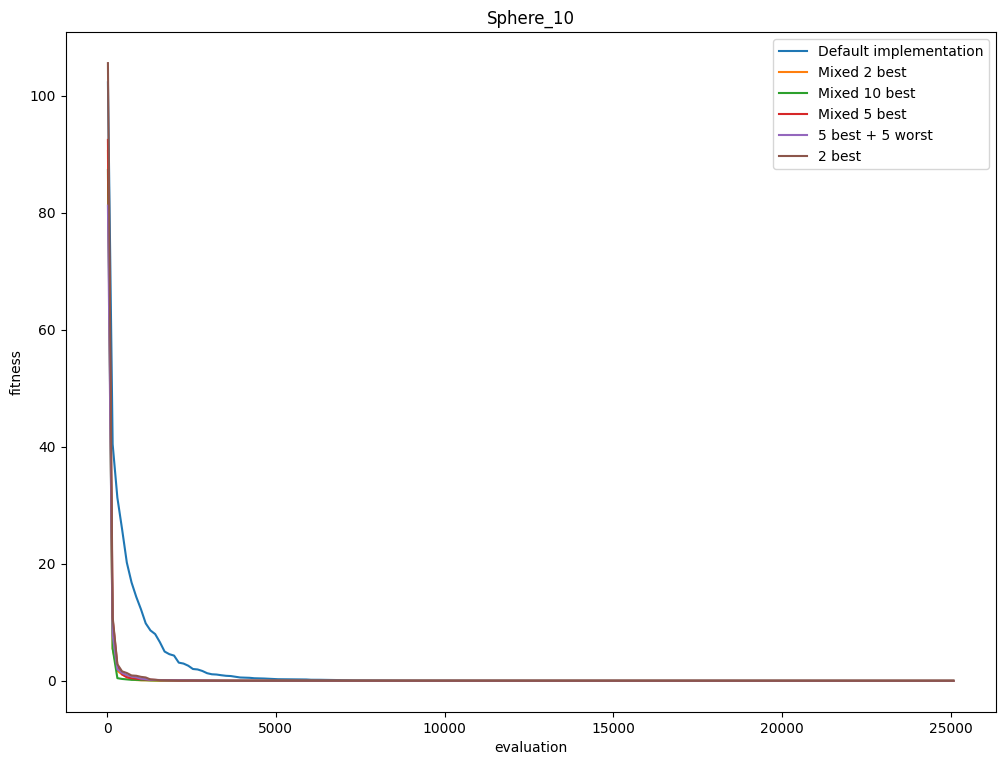

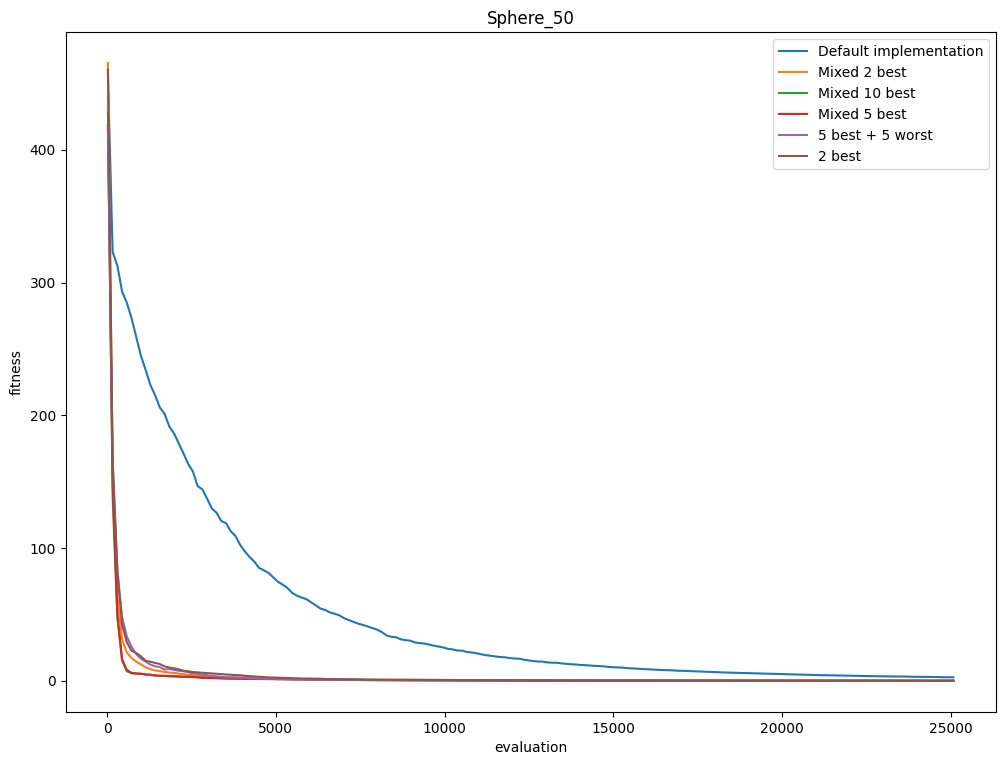

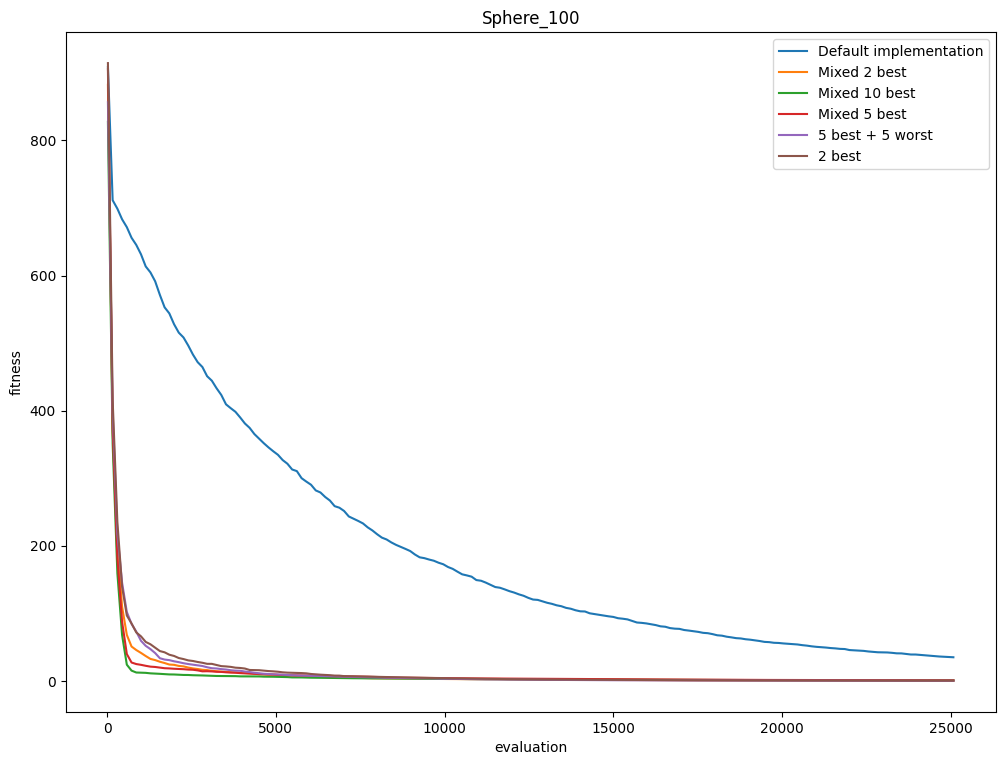

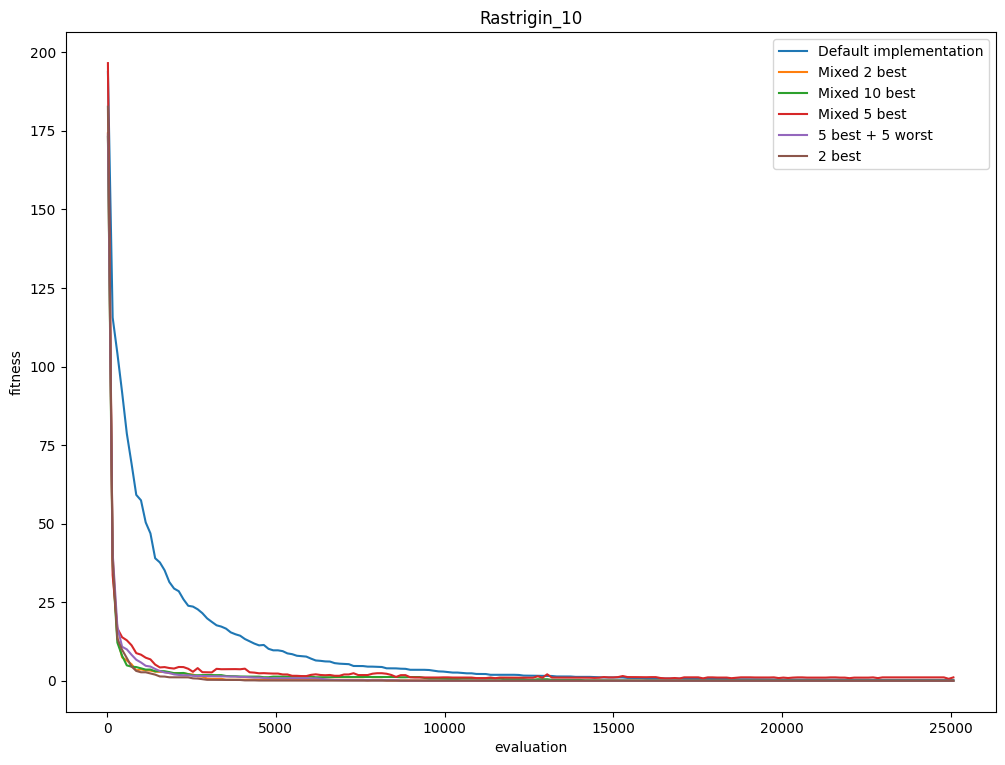

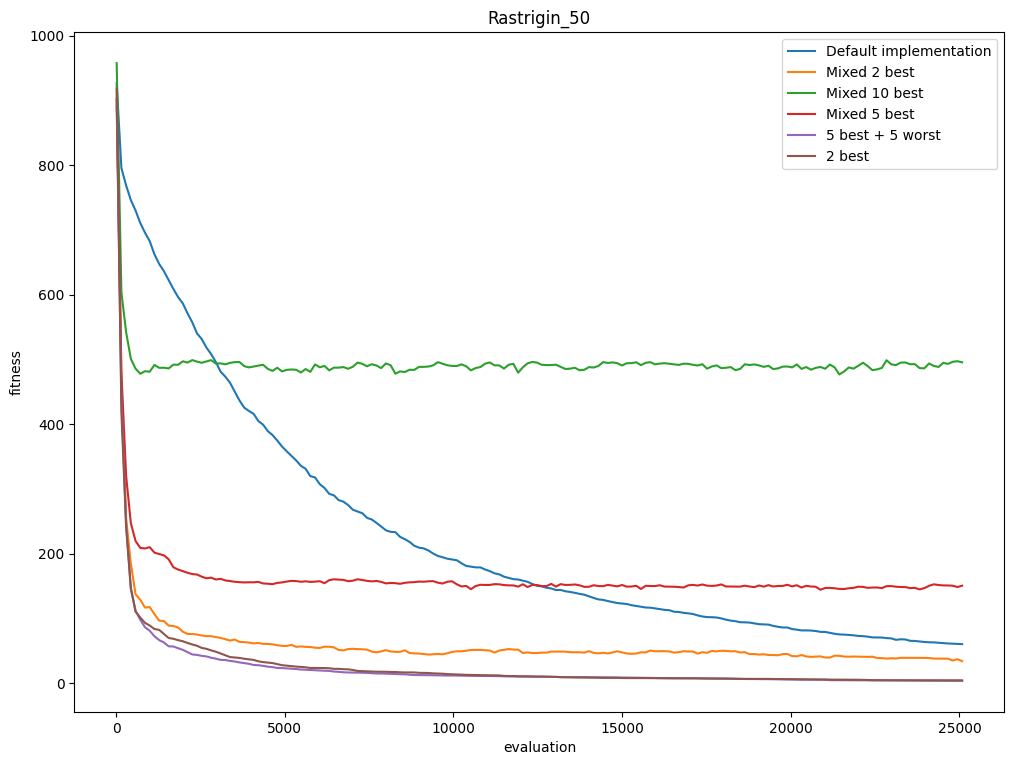

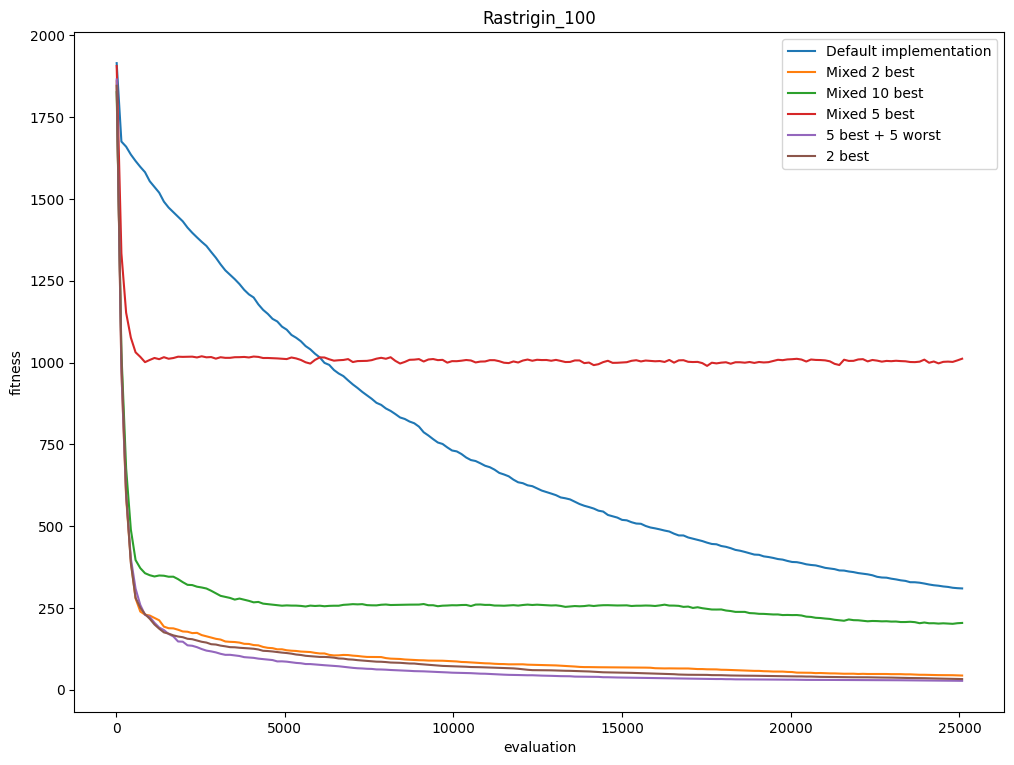

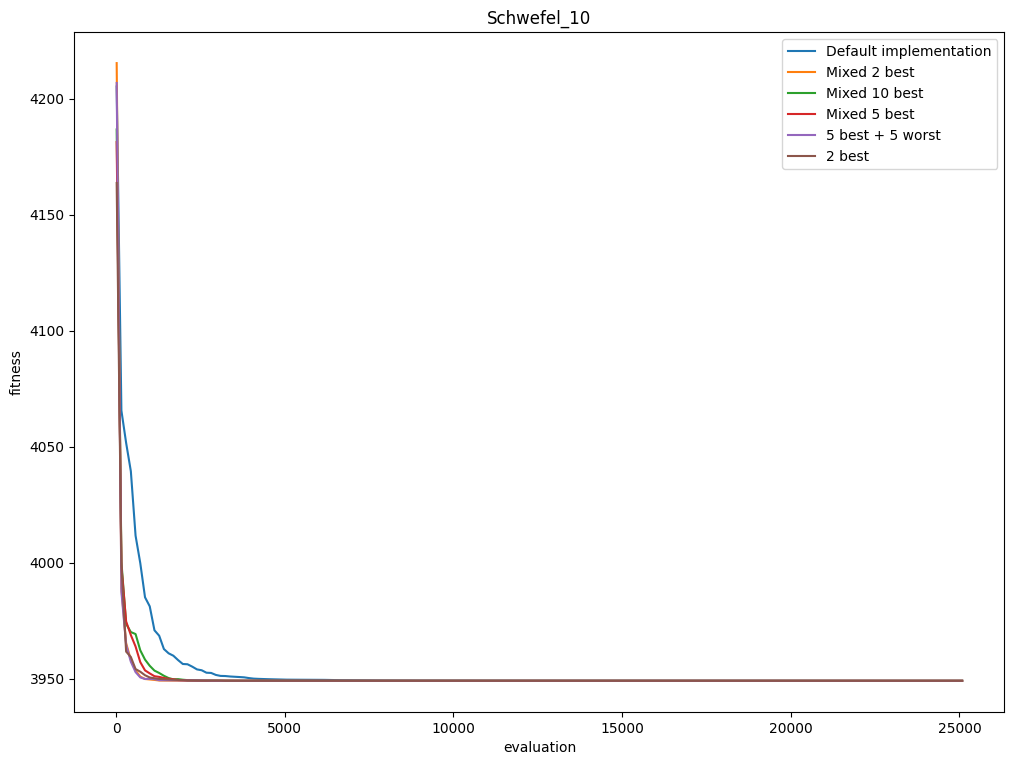

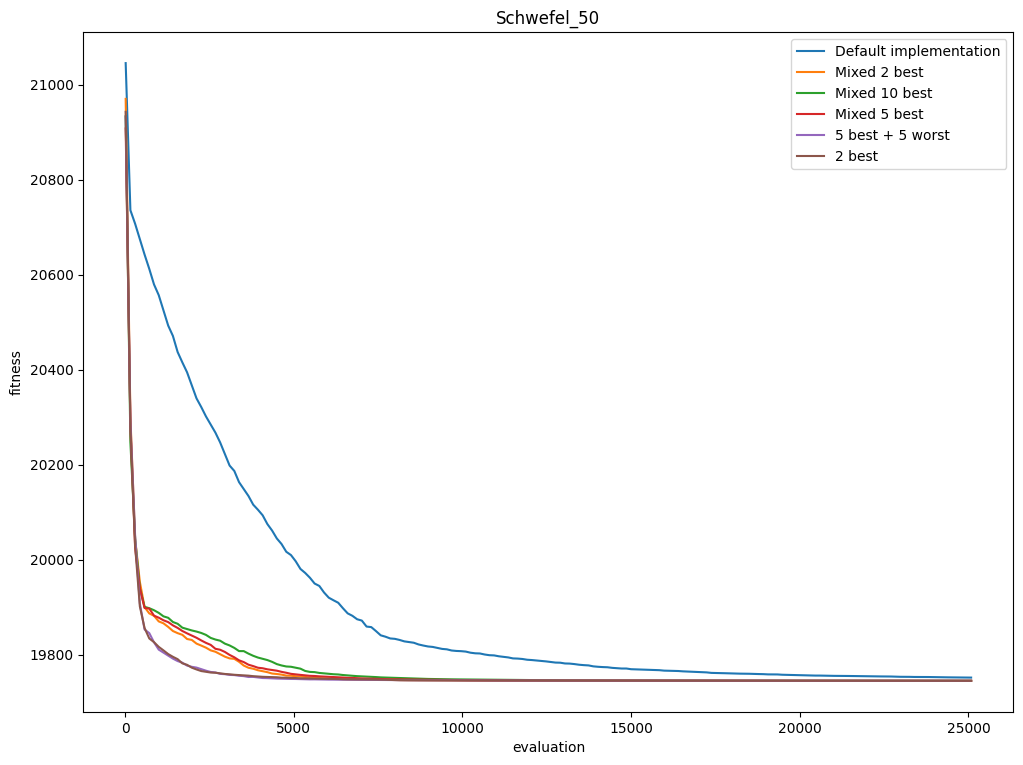

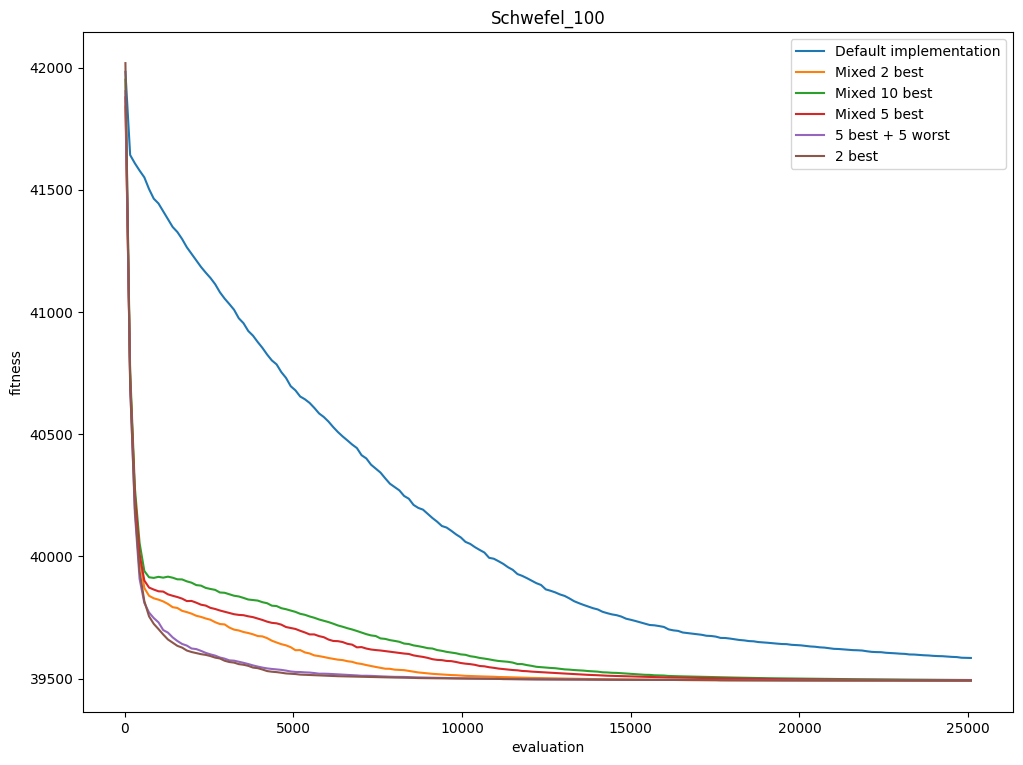

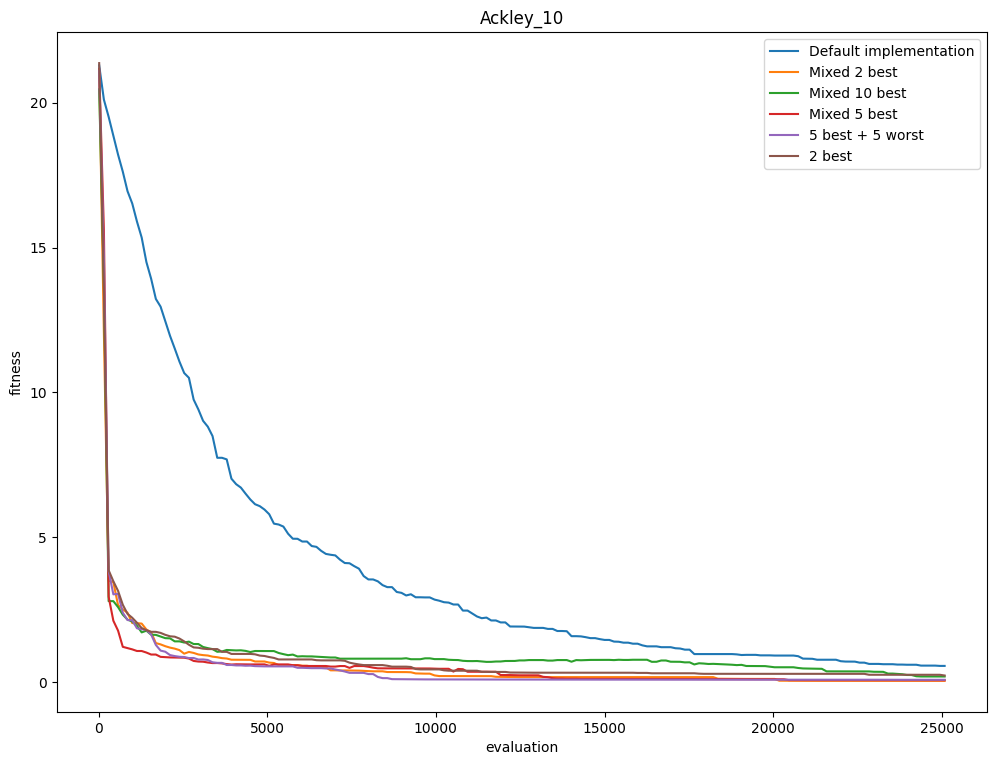

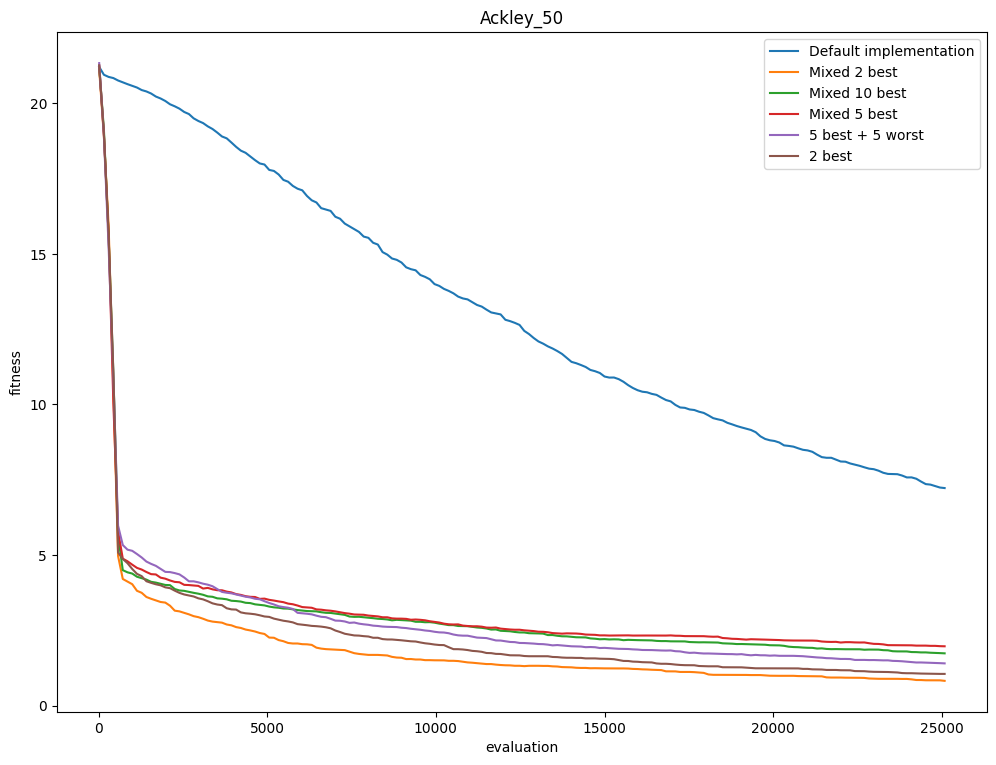

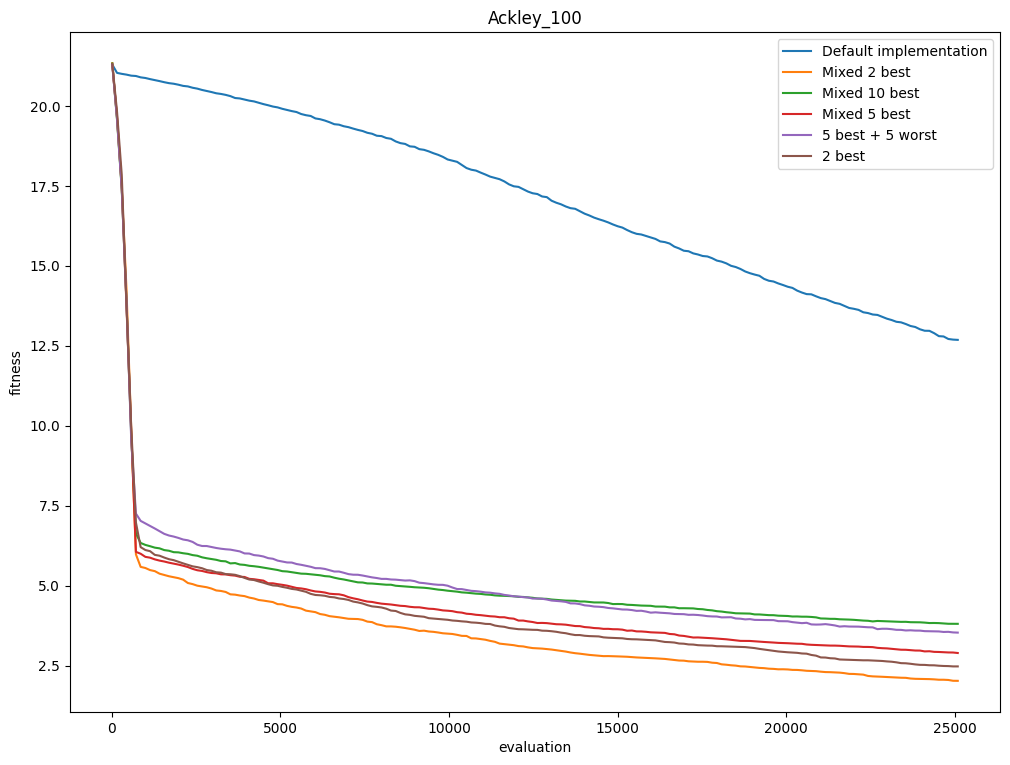

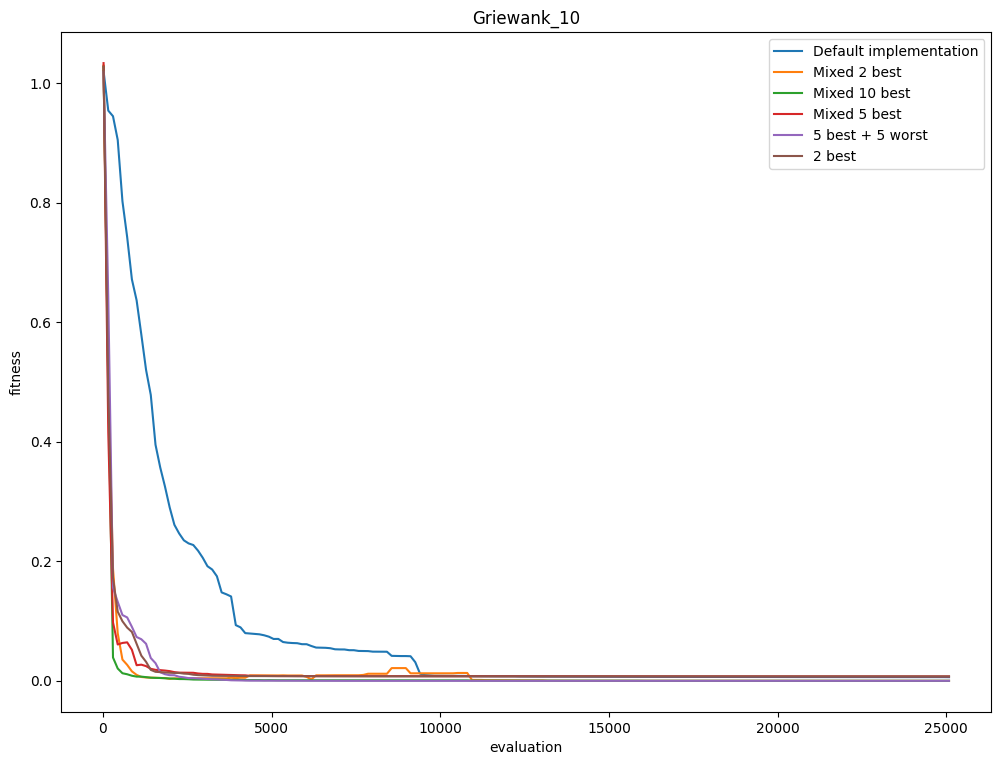

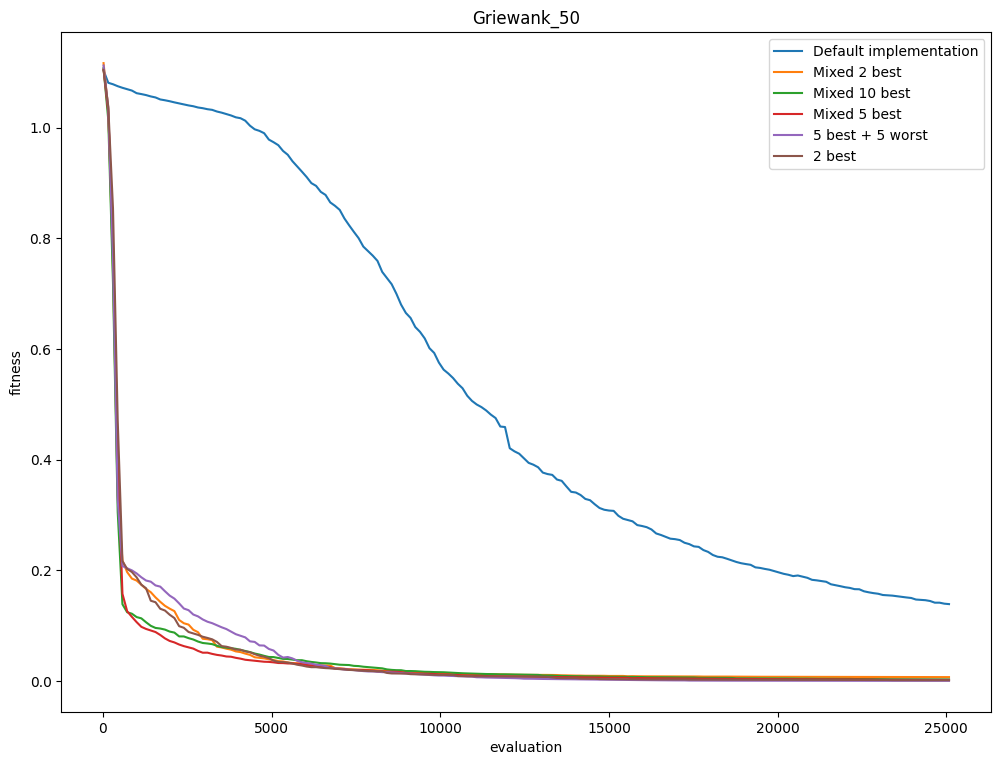

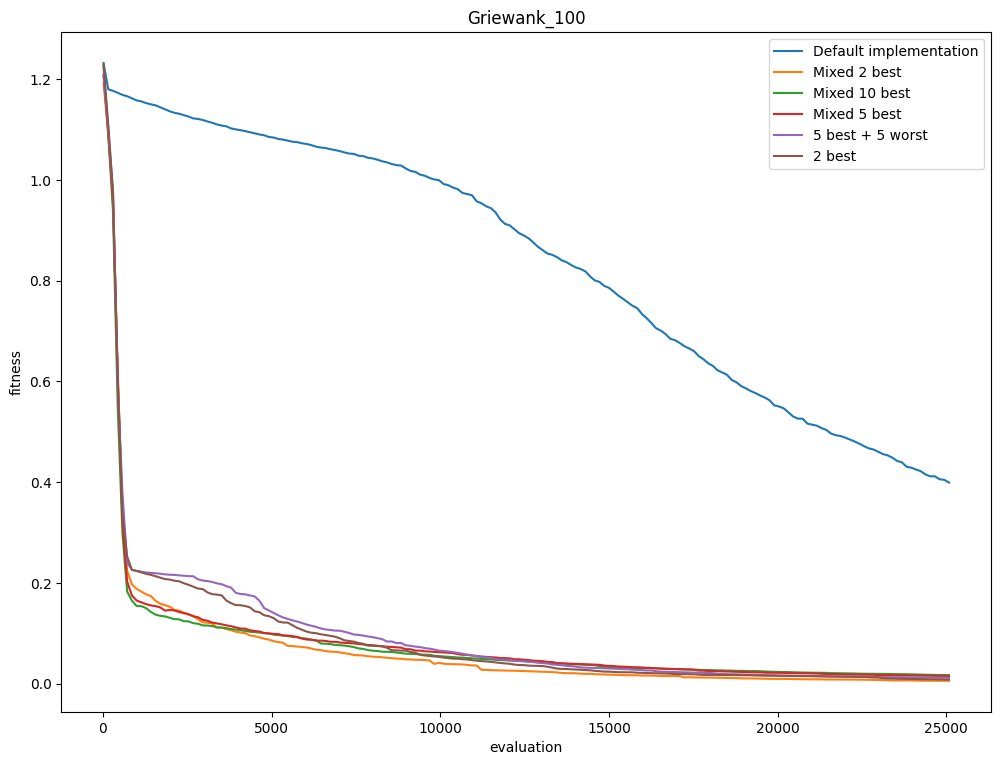

In [15]:
mu=20
lambda_=140 
elitist=False
max_evaluations=25000
repeats=5

run_simulation(mu, lambda_, elitist, max_evaluations, repeats)


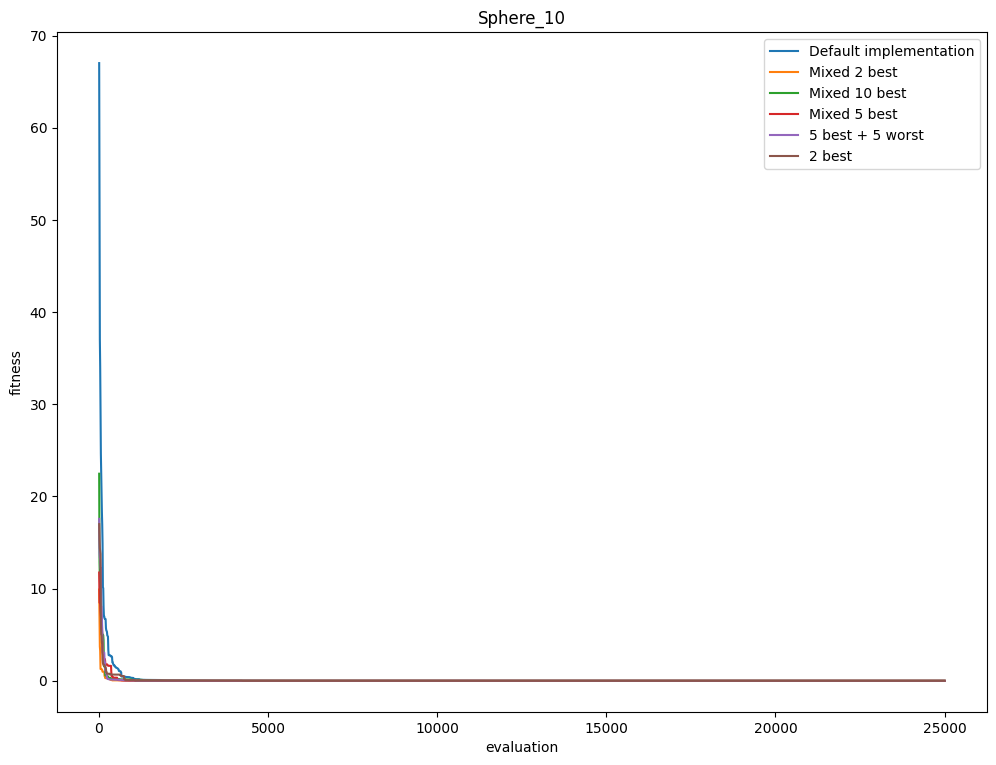

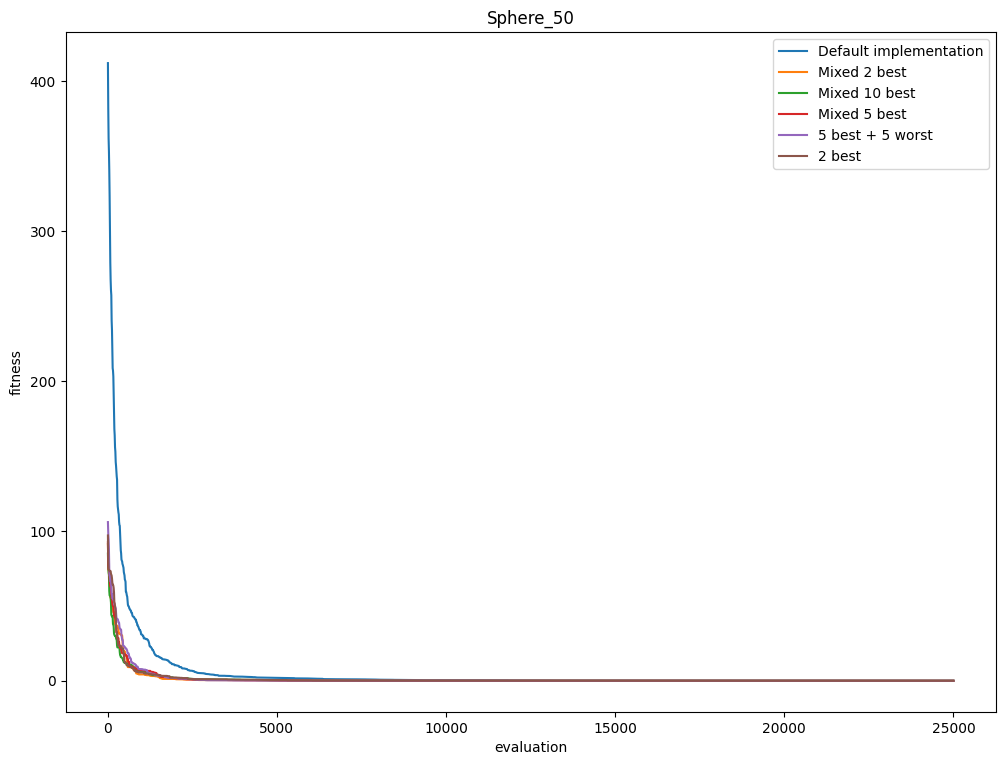

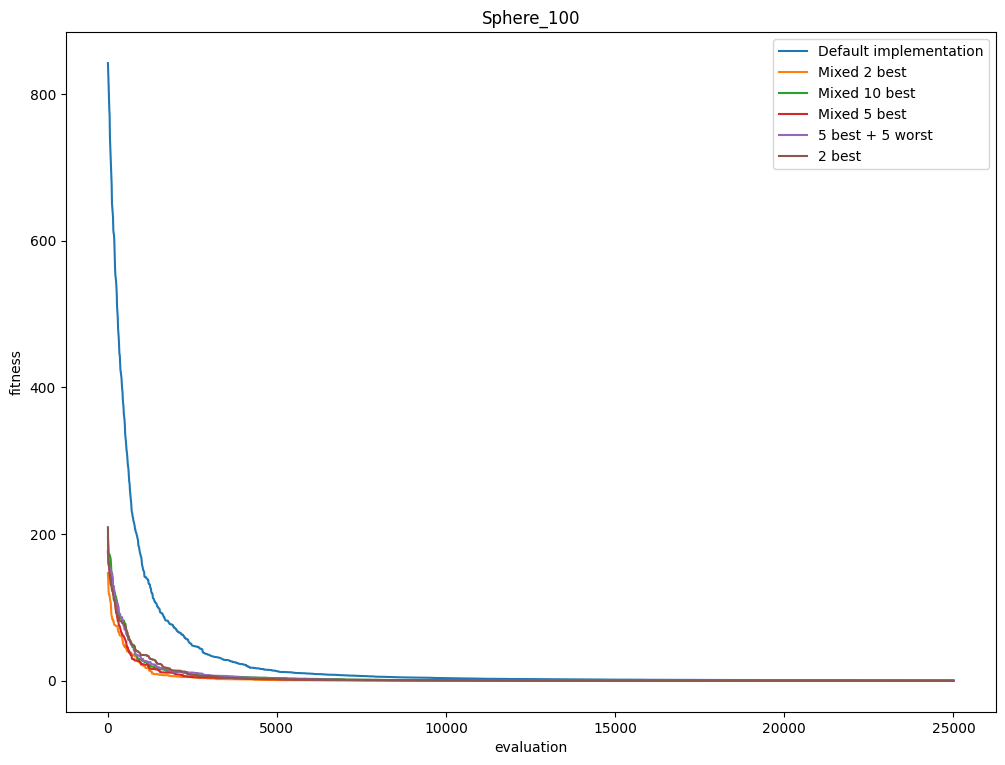

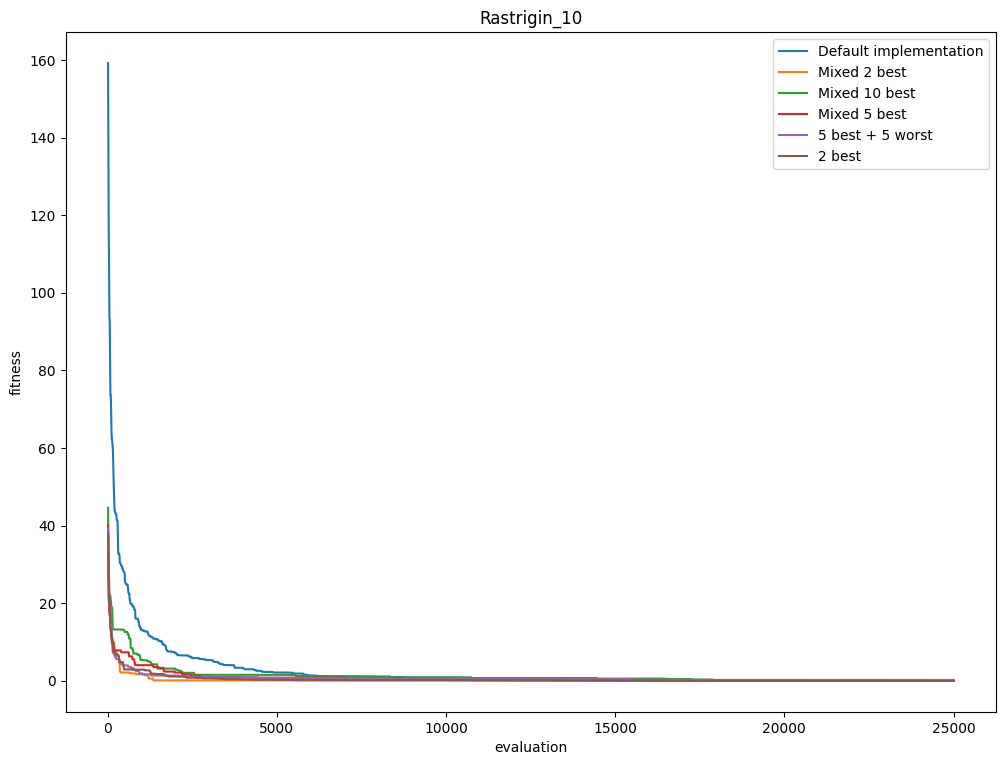

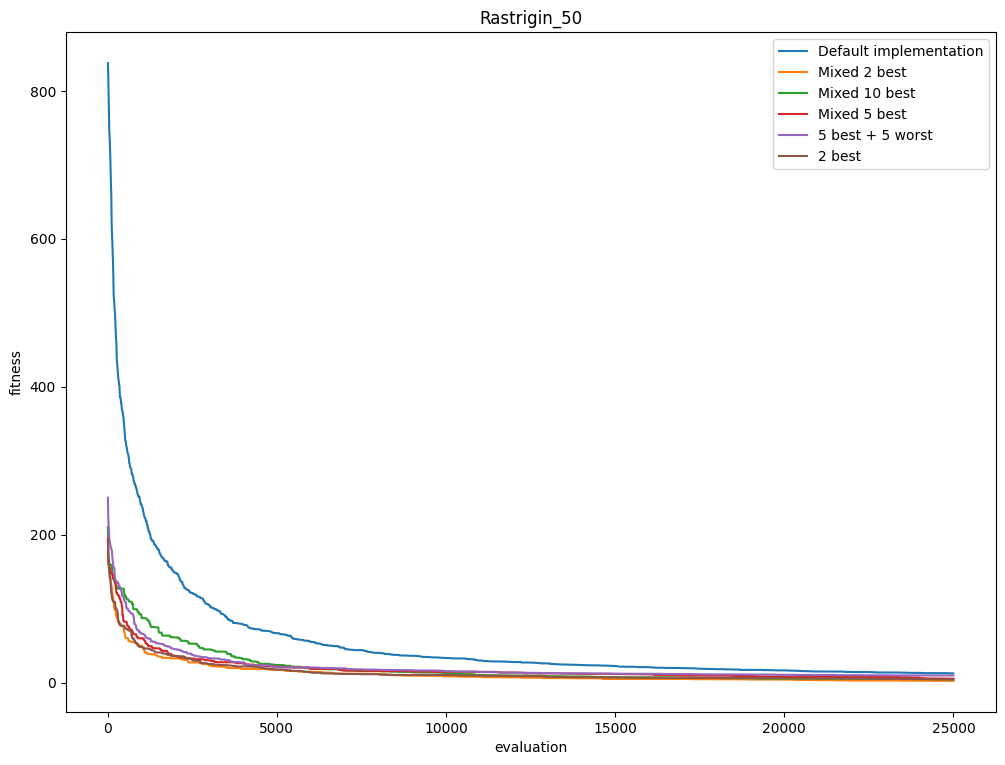

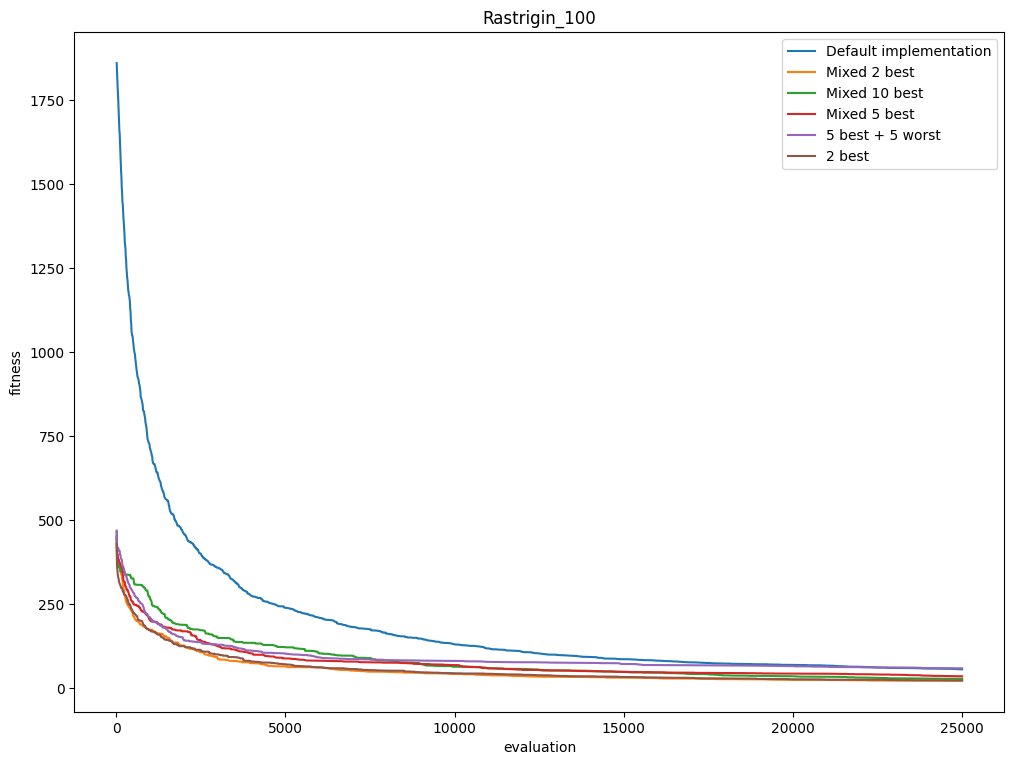

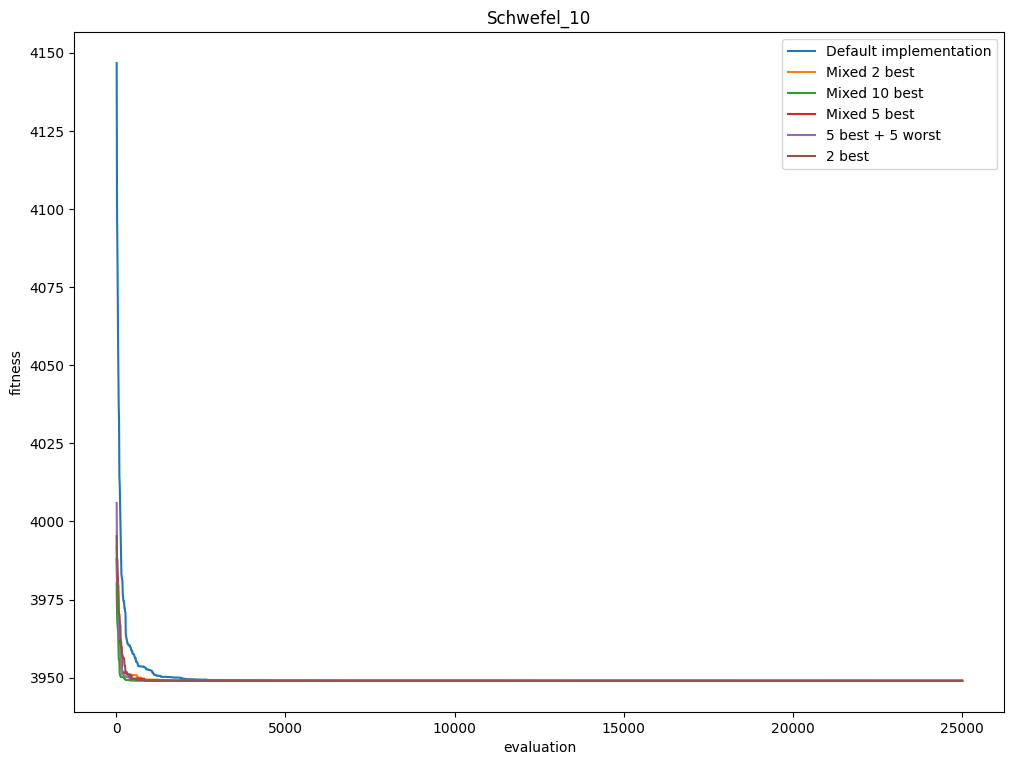

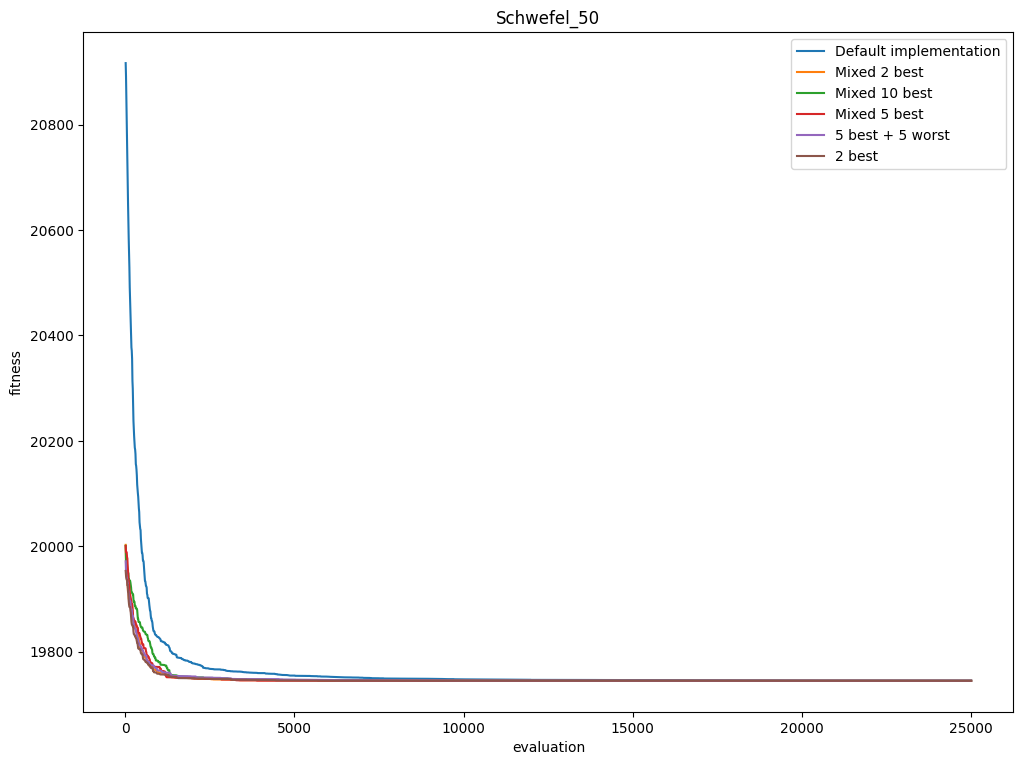

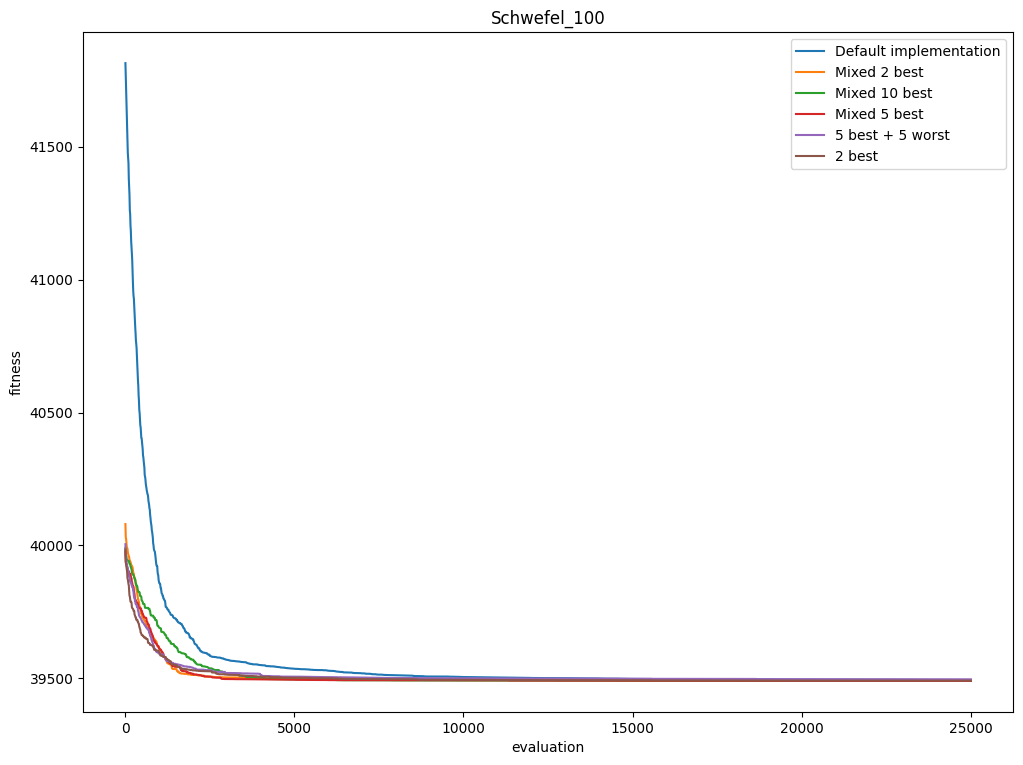

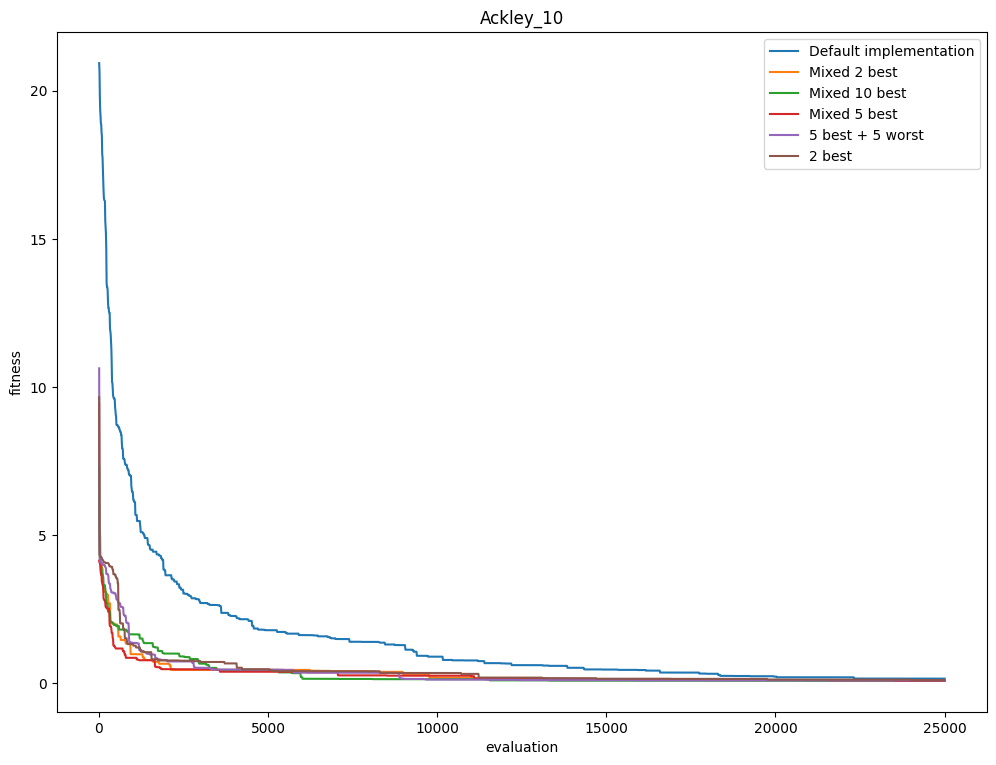

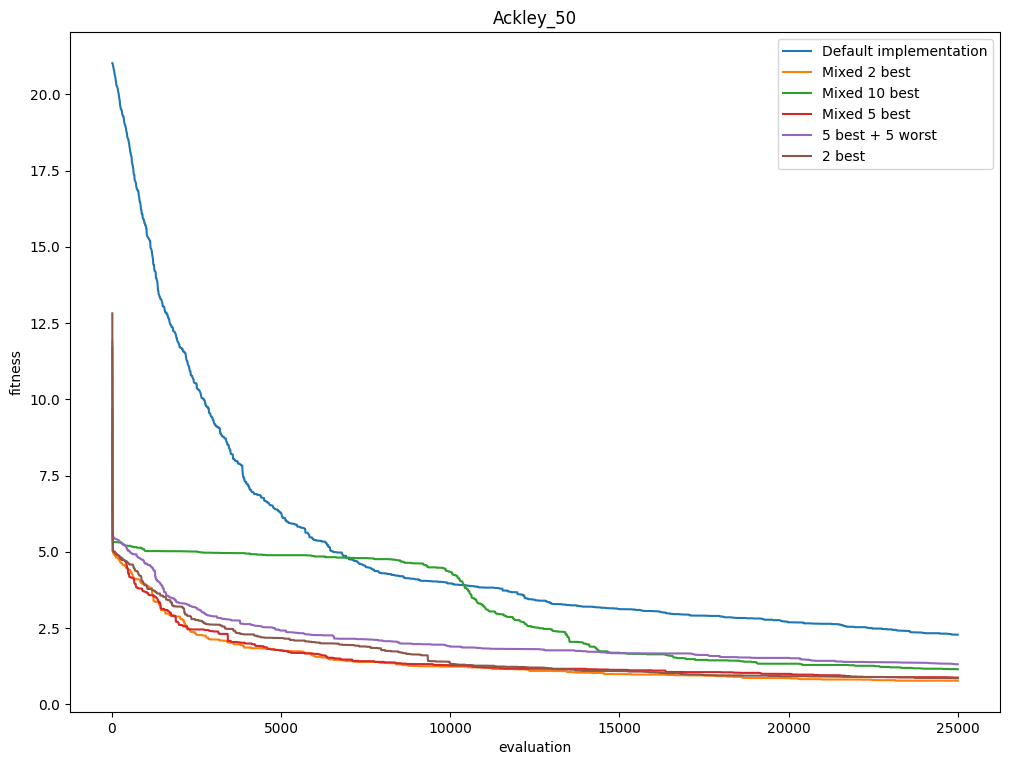

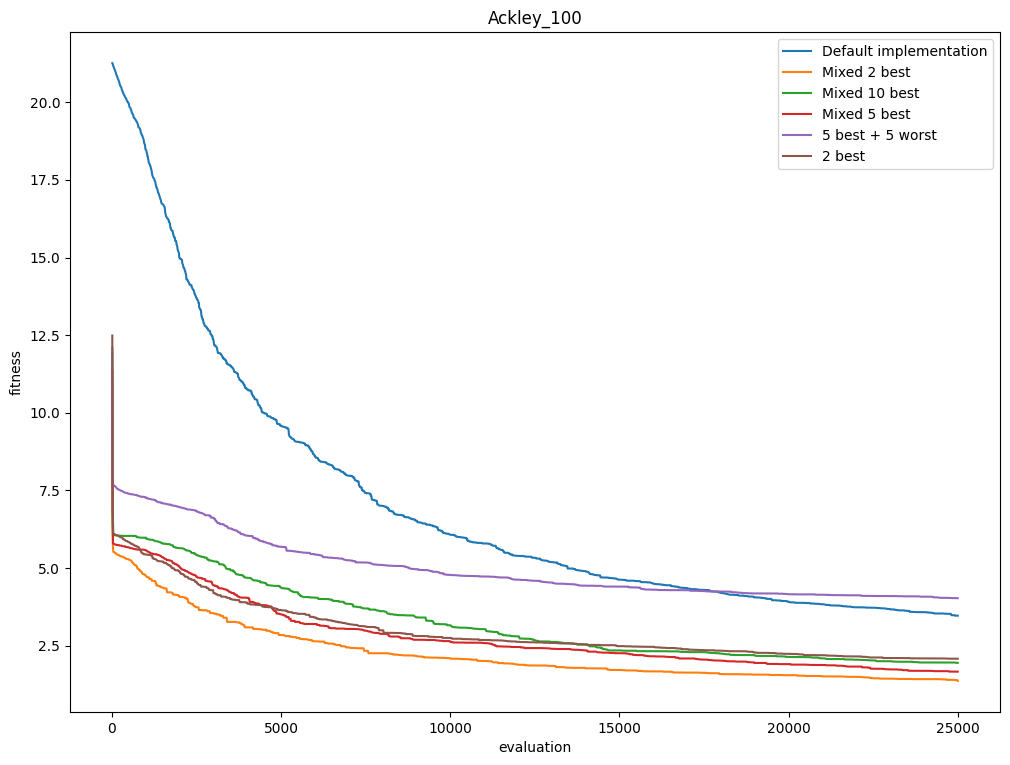

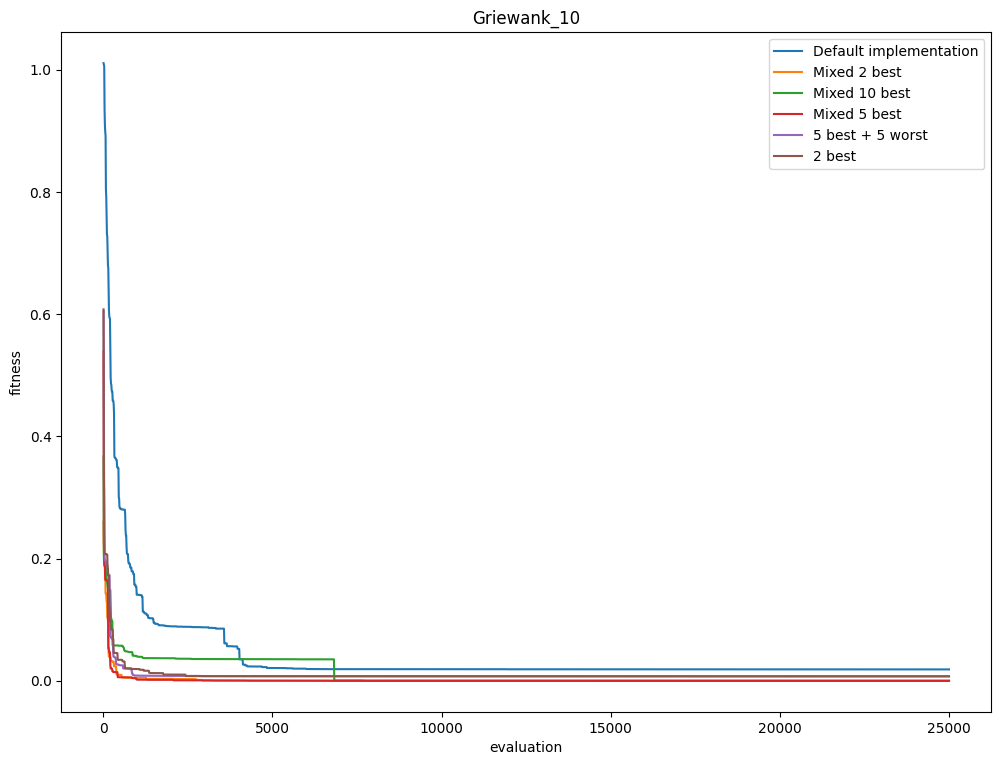

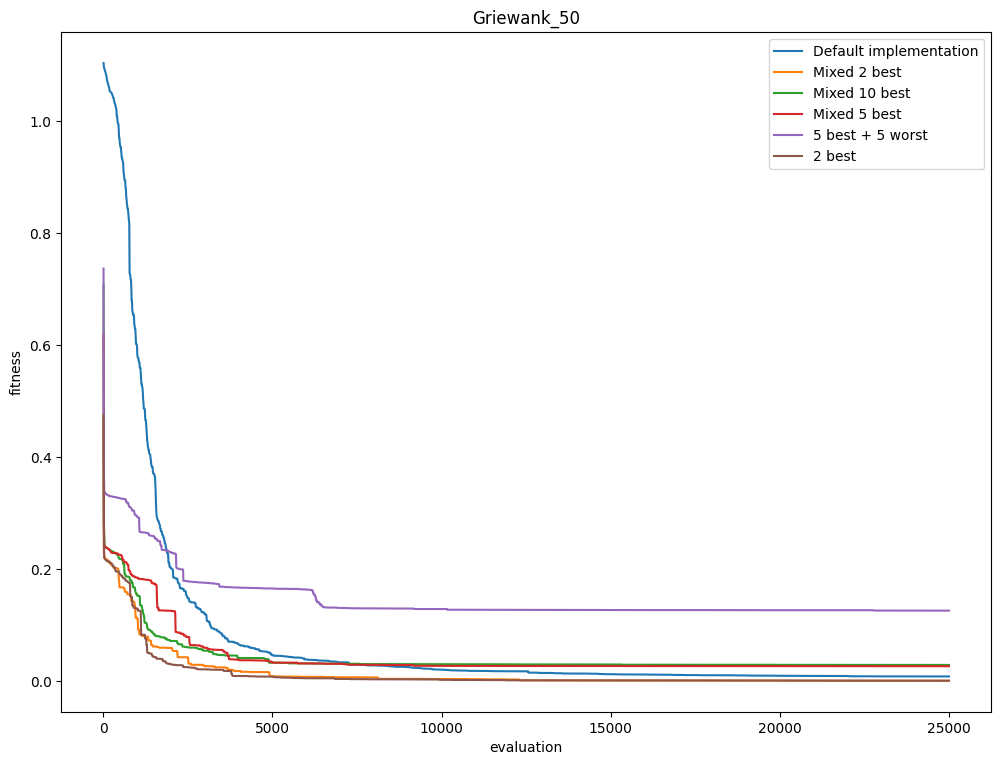

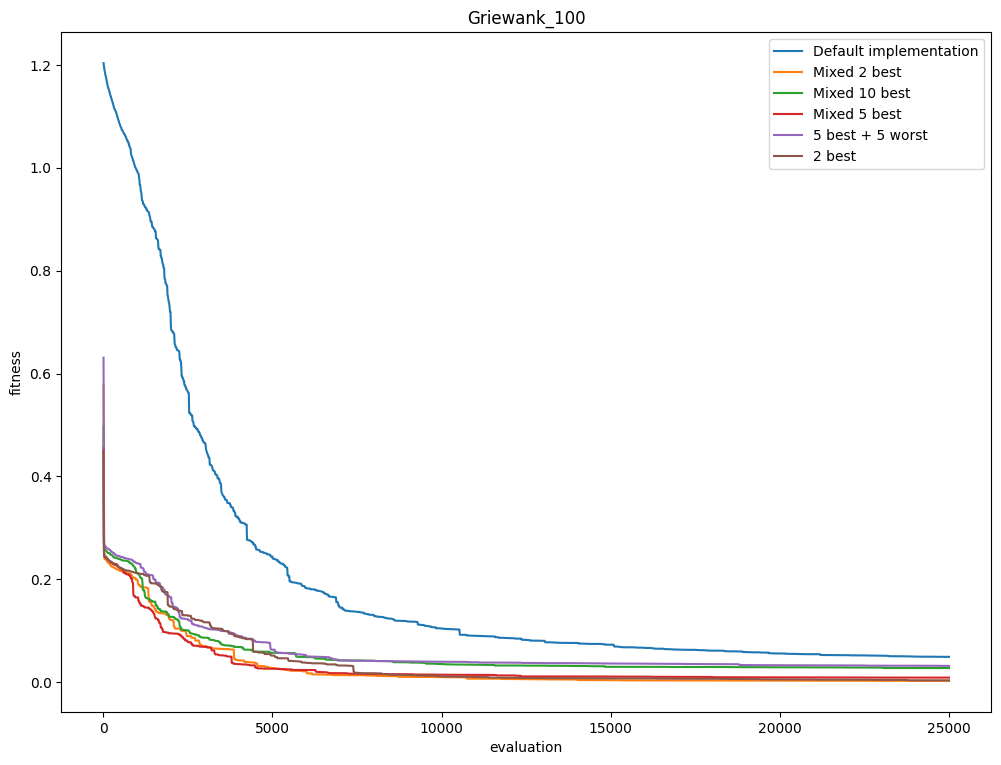

In [16]:
mu=1
lambda_=1
elitist=True
max_evaluations=25000
repeats=5

run_simulation(mu, lambda_, elitist, max_evaluations, repeats)
